```{try_on_binder}
```

In [1]:
from IPython import get_ipython
ip = get_ipython()
if ip is not None:
    ip.run_line_magic('load_ext', 'pymor.discretizers.builtin.gui.jupyter')
    ip.run_line_magic('matplotlib', 'inline')

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='torch')
import pymor.tools.random
pymor.tools.random._default_random_state = None


The pymor.discretizers.builtin.gui.jupyter extension is already loaded. To reload it, use:
  %reload_ext pymor.discretizers.builtin.gui.jupyter


Tutorial: Building a Reduced Basis
==================================




In this tutorial we will learn more about {{ VectorArrays }} and how to
construct a reduced basis using pyMOR.

A reduced basis spans a low dimensional subspace of a {{ Model }}'s
{attr}`~pymor.models.interface.Model.solution_space`, in which the
{meth}`solutions <pymor.models.interface.Model.solve>` of the {{ Model }}
can be well approximated for all {{ parameter_values }}. In this context,
time is treated as an additional parameter. So for time-dependent problems,
the reduced space (the span of the reduced basis) should approximate the
solution for all {{ parameter_values }} and time instances.

An upper bound for the possible quality of a reduced space is given by the so-called
Kolmogorov {math}`N`-width {math}`d_N` given as

```{math}
d_N := \inf_{\substack{V_N \subseteq V\\ \operatorname{dim}(V_N) \leq N}}\,
       \sup_{\mu \in \mathcal{P}}\,
       \inf_{v \in V_N}\,
       \|u(\mu) - v\|.
```

In this formula {math}`V` denotes the
{attr}`~pymor.models.interface.Model.solution_space`, {math}`\mathcal{P} \subset \mathbb{R}^p`
denotes the set of all {{ parameter_values }} we are interested in, and
{math}`u(\mu)` denotes the {meth}`solution <pymor.models.interface.Model.solve>`
of the {{ Model }} for the given {{ parameter_values }} {math}`\mu`.
In pyMOR the set {math}`\mathcal{P}` is called the {{ ParameterSpace }}.

How to read this formula? For each candidate reduced space {math}`V_N` we
look at all possible {{ parameter_values }} {math}`\mu` and compute the best-approximation
error in {math}`V_N` (the second infimum). The supremum over the infimum
is thus the worst-case best-approximation error over all {{ parameter_values }} of
interest. Now we take the infimum of the worst-case best-approximation errors
over all possible reduced spaces of dimension at most {math}`N`, and this is
{math}`d_N`.

So whatever reduced space of dimension {math}`N` we pick, we
will always find a {math}`\mu` for which the best-approximation error in our
space is at least {math}`d_N`. Reduced basis methods aim at constructing
spaces {math}`V_N` for which the worst-case best-approximation error is as
close to {math}`d_N` as possible.

However, we will only find a good {math}`V_N` of small dimension
{math}`N` if the values {math}`d_N` decrease quickly for growing
{math}`N`. It can be shown that this is the case as soon as {math}`u(\mu)`
analytically depends on {math}`\mu`, which is true for many problems
of interest. More precisely, it can be shown {cite}`BCDDPW11`, {cite}`DPW13` that there are constants
{math}`C, c > 0` such that

$$ d_N \leq C \cdot e^{-N^c}. $$

In this tutorial we will construct reduced spaces {math}`V_N` for a concrete problem
with pyMOR and study their error decay.


Model setup
-----------

First we need to define a {{ Model }} and a {{ ParameterSpace }} for which we want
to build a reduced basis. We choose here the standard
{meth}`thermal block <pymor.analyticalproblems.thermalblock.thermal_block_problem>` benchmark
problem shipped with pyMOR (see {doc}`getting_started`). However, any pyMOR
{{ Model }} can be used, except for Section [Weak Greedy Algorithm](#weak-greedy-algorithm) where
some more assumptions have to be made on the {{ Model }}.

First we import everything we need:

In [2]:
import numpy as np
from pymor.basic import *

/builds/pymor/pymor/src/pymor/core/config.py:49: UserWarning: dune-gdt bindings have been tested for version 2021.1.x (x >= 2) (installed: 2022.1.1.603).
  warnings.warn('dune-gdt bindings have been tested for version 2021.1.x (x >= 2) '
/builds/pymor/pymor/src/pymor/core/config.py:57: UserWarning: dune-gdt bindings have been tested for dune-xt 2021.1.x (x >= 2) (installed: 2022.1.4.601).
  warnings.warn('dune-gdt bindings have been tested for dune-xt 2021.1.x (x >= 2) '


Then we build a 3-by-3 thermalblock problem that we discretize using pyMOR's
{mod}`builtin discretizers <pymor.discretizers.builtin>` (see
{doc}`tutorial_builtin_discretizer` for an introduction to pyMOR's discretization toolkit).

In [3]:
problem = thermal_block_problem((3,3))
fom, _ = discretize_stationary_cg(problem, diameter=1/100)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

Next, we need to define a {{ ParameterSpace }} of {{ parameter_values }} for which
the solutions of the full-order model `fom` should be approximated by the reduced basis.
We do this by calling the {meth}`~pymor.parameters.base.Parameters.space` method
of the |parameters| of `fom`:

In [4]:
parameter_space = fom.parameters.space(0.0001, 1.)

Here, `0.0001` and `1.` are the common lower and upper bounds for the
individual components of all |parameters| of `fom`. In our case `fom`
expects a single parameter `'diffusion'` of 9 values:

In [5]:
fom.parameters

Parameters({diffusion: 9})

If `fom` were to depend on multiple |parameters|, we could also call the
{meth}`~pymor.parameters.base.Parameters.space` method with a dictionary
of lower and upper bounds per parameter.

The main use of {{ ParameterSpaces }} in pyMOR is that they allow to easily sample
{{ parameter_values }} from their domain using the methods
{meth}`~pymor.parameters.base.ParameterSpace.sample_uniformly` and
{meth}`~pymor.parameters.base.ParameterSpace.sample_randomly`.


Computing the snapshot data
---------------------------

Reduced basis methods are snapshot-based, which means that they build
the reduced space as a linear subspace of the linear span of solutions
of the `fom` for certain {{ parameter_values }}. The easiest
approach is to just pick these values randomly, what we will do in the
following. First we define a training set of 25 parameters:

In [6]:
training_set = parameter_space.sample_randomly(25)
print(training_set)

[Mu({'diffusion': array([0.37460266, 0.95071923, 0.73202074, 0.59869862, 0.15610304,
       0.15607892, 0.0581778 , 0.86618953, 0.6011549 ])}), Mu({'diffusion': array([0.70810177, 0.02068244, 0.96991286, 0.8324594 , 0.21241788,
       0.18190678, 0.18348617, 0.30431182, 0.52480396])}), Mu({'diffusion': array([0.43200182, 0.29130002, 0.61189171, 0.13957991, 0.29221543,
       0.36642521, 0.45612438, 0.78519744, 0.19975381])}), Mu({'diffusion': array([0.51428301, 0.59245533, 0.04654577, 0.6075841 , 0.17060707,
       0.06514509, 0.94889065, 0.96563547, 0.80841651])}), Mu({'diffusion': array([0.30468331, 0.09776235, 0.6842646 , 0.44020848, 0.12212603,
       0.49522739, 0.03448508, 0.90932947, 0.2588541 ])}), Mu({'diffusion': array([0.66255603, 0.3117799 , 0.52011601, 0.54675561, 0.18493597,
       0.96958767, 0.77515531, 0.93950499, 0.89483787])}), Mu({'diffusion': array([0.59794019, 0.92188205, 0.08858365, 0.19606326, 0.04532277,
       0.3253978 , 0.38873842, 0.2714219 , 0.82875464])})

Then we {meth}`~pymor.models.interface.Model.solve` the full-order model
for all {{ parameter_values }} in the training set and accumulate all
solution vectors in a single {{ VectorArray }} using its
{meth}`~pymor.vectorarrays.interface.VectorArray.append` method. But first
we need to create an empty {{ VectorArray }} to which the solutions can
be appended. New {{ VectorArrays }} in pyMOR are always created by a
corresponding {{ VectorSpace }}. Empty arrays are created using the
{meth}`~pymor.vectorarrays.interface.VectorSpace.empty` method. But what
is the right {{ VectorSpace }}? All {meth}`solutions <pymor.models.interface.Model.solve>`
of a {{ Model }} belong to its {attr}`~pymor.models.interface.Model.solution_space`,
so we write:

In [7]:
U = fom.solution_space.empty()
for mu in training_set:
    U.append(fom.solve(mu))

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

Note that `fom.solve` returns a {{ VectorArray }} containing a single vector.
This entire array (of one vector) is then appended to the `U` array.
pyMOR has no notion of single vectors, we only speak of {{ VectorArrays }}.

What exactly is a {{ VectorSpace }}? A {{ VectorSpace }} in pyMOR holds all
information necessary to build {{ VectorArrays }} containing vector objects
of a certain type. In our case we have

In [8]:
fom.solution_space

NumpyVectorSpace(20201, id='STATE')

which means that the created {{ VectorArrays }} will internally hold
{{ NumPy_arrays }} for data storage. The number is the dimension of the
vector. We have here a {{ NumpyVectorSpace }} because pyMOR's builtin
discretizations are built around the NumPy/SciPy stack. If `fom` would
represent a {{ Model }} living in an external PDE solver, we would have
a different type of {{ VectorSpace }} which, for instance, might hold a
reference to a discrete functions space object inside the PDE solver
instead of the dimension.

After appending all solutions vectors to `U`, we can verify that `U`
now really contains 25 vectors:

In [9]:
len(U)

25

Note that appending one {{ VectorArray }} `V` to another array `U`
will append copies of the vectors in `V` to `U`. So
modifying `U` will not affect `V`.

Let's look at the solution snapshots we have just computed using
the {meth}`~pymor.models.interface.Model.visualize` method of `fom`.
A {{ VectorArray }} containing multiple vectors is visualized as a
time series:

In [10]:
fom.visualize(U)

<pymor.discretizers.builtin.gui.jupyter.matplotlib.visualize_patch.<locals>.Plot at 0x7f989abe0160>

A trivial reduced basis
-----------------------

Given some snapshot data, the easiest option to get a reduced basis
is to just use the snapshot vectors as the basis:

In [11]:
trivial_basis = U.copy()

Note that assignment in Python never copies data! Thus, if we had written
`trivial_basis = U` and modified `trivial_basis`, `U` would change
as well, since `trivial_basis` and `U` would refer to the same
{{ VectorArray }} object. So whenever you want to use one {{ VectorArray }}
somewhere else and you are unsure whether some code might change the
array, you should always create a copy. pyMOR uses copy-on-write semantics
for copies of {{ VectorArrays }}, which means that generally calling
{meth}`~pymor.vectorarrays.interface.VectorArray.copy` is cheap as it does
not duplicate any data in memory. Only when you modify one of the arrays
the data will be copied.

Now we want to know how good our reduced basis is. So we want to compute

$$ \inf_{v \in V_N}\ \|u(\mu) - v\|, $$

where {math}`V_N` denotes the span of our reduced basis, for all
{math}`\mu` in some validation set of {{ parameter_values }}. Assuming that
we are in a Hilbert space, we can compute the infimum via orthogonal
projection onto {math}`V_N`: in that case, the projection will be the
best approximation in {math}`V_N` and the norm of the difference between
{math}`u(\mu)` and its orthogonal projection will be the best-approximation
error.

So let {math}`v_{proj}` be the orthogonal projection of {math}`v` onto the
linear space spanned by the basis vectors {math}`u_i,\ i=1, \ldots, N`.
By definition this means that {math}`v - v_{proj}` is orthogonal to
all {math}`u_i`:

$$ (v - v_{proj}, u_i) = 0, \qquad i = 1, \ldots, N. $$

Let {math}`\lambda_j`, {math}`j = 1, \ldots, N` be the coefficients of
{math}`v_{proj}` with respect to  this basis, i.e.
{math}`\sum_{j=1}^N \lambda_j u_j = v_{proj}`. Then:

$$ \sum_{j=1}^N \lambda_j (u_j, u_i) = (v, u_i), \qquad i = 1, \ldots, N.$$

With {math}`G_{i,j} := (u_i, u_j)`,
{math}`R := [(v, u_1), \ldots, (v, u_N)]^T` and
{math}`\Lambda := [\lambda_1, \ldots, \lambda_N]^T`, we obtain the
linear equation system

$$  G \cdot \Lambda = R,$$

which determines {math}`\lambda_i` and, thus, {math}`v_{proj}`.

Let's assemble and solve this equation system using pyMOR to determine
the best-approximation error in `trivial_basis` for some test vector
`V` which we take as another random solution of our {{ Model }}:

In [12]:
V = fom.solve(parameter_space.sample_randomly())

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

The matrix {math}`G` of all inner products between vectors in `trivial_basis`
is a so called [Gramian matrix](<https://en.wikipedia.org/wiki/Gramian_matrix>).
Consequently, every {{ VectorArray }} has a {meth}`~pymor.vectorarrays.interface.VectorArray.gramian` method, which computes precisely
this matrix:

In [13]:
G = trivial_basis.gramian()

The Gramian is computed w.r.t. the Euclidean inner product. For the
right-hand side {math}`R`, we need to compute all (Euclidean) inner
products between the vectors in `trivial_basis` and (the single vector in)
`V`. For that, we can use the {meth}`~pymor.vectorarrays.interface.VectorArray.inner`
method:

In [14]:
R = trivial_basis.inner(V)

which will give us a {math}`25\times 1` {{ NumPy_array }} of all inner products.

In [15]:
assert R.shape == (25,1)

Now, we can use {{ NumPy }} to solve the linear equation system:

In [16]:
lambdas = np.linalg.solve(G, R)

Finally, we need to form the linear combination

$$ \sum_{j=1}^N \lambda_j u_j = v_{proj} $$

using the {meth}`~pymor.vectorarrays.interface.VectorArray.lincomb` method
of `trivial_basis`. It expects row vectors of linear coefficients, but
`solve` returns column vectors, so we need to take the transpose:

In [17]:
V_proj = trivial_basis.lincomb(lambdas.T)

Let's look at `V`, `V_proj` and the difference of both. {{ VectorArrays }} of
the same length can simply be subtracted, yielding a new array of the
differences:

In [18]:
# for some reason V_proj does not carry over from the previous cell
V_proj = trivial_basis.lincomb(lambdas.T)
fom.visualize((V, V_proj, V - V_proj),
              legend=('V', 'V_proj', 'best-approximation err'),
              separate_colorbars=True)

Output()

As you can see, we already have a quite good approximation of `V` with
only 25 basis vectors.

Now, the Euclidean norm will just work fine in many cases.
However, when the full-order model comes from a PDE, it will be usually not the norm
we are interested in, and you may get poor results for problems with
strongly anisotropic meshes.

For our diffusion problem with homogeneous Dirichlet boundaries,
the Sobolev semi-norm (of order one) is a natural choice. Among other useful products,
{meth}`~pymor.discretizers.builtin.cg.discretize_stationary_cg` already
assembled a corresponding inner product {{ Operator }} for us, which is available
as

In [19]:
fom.h1_0_semi_product

NumpyMatrixOperator(<20201x20201 sparse, 140601 nnz>, source_id='STATE', range_id='STATE', name='h1_0_semi')

```{note}
The `0` in `h1_0_semi_product` refers to the fact that rows and columns of
Dirichlet boundary DOFs have been cleared in the matrix of the Operator to
make it invertible. This is important for being able to compute Riesz
representatives w.r.t. this inner product (required for a posteriori
estimation of the ROM error). If you want to compute the H1 semi-norm of a
function that does not vanish at the Dirichlet boundary, use
`fom.h1_semi_product`.
```

To use `fom.h1_0_semi_product` as an inner product {{ Operator }} for computing the
projection error, we can simply pass it as the optional `product` argument to
{meth}`~pymor.vectorarrays.interface.VectorArray.gramian` and
{meth}`~pymor.vectorarrays.interface.VectorArray.inner`:

In [20]:
G = trivial_basis[:10].gramian(product=fom.h1_0_semi_product)
R = trivial_basis[:10].inner(V, product=fom.h1_0_semi_product)
lambdas = np.linalg.solve(G, R)
V_h1_proj = trivial_basis[:10].lincomb(lambdas.T)

fom.visualize((V, V_h1_proj, V - V_h1_proj), separate_colorbars=True)

Output()

As you might have guessed, we have additionally opted here to only use the
span of the first 10 basis vectors of `trivial_basis`. Like {{ NumPy_arrays }},
{{ VectorArrays }} can be sliced and indexed. The result is *always* a
{attr}`view <pymor.vectorarrays.interface.VectorArray.is_view>` onto the
original data. If the view object is modified, the original array is modified
as well.

Next we will assess the approximation error a bit more thoroughly, by
evaluating it on a validation set of 100 {{ parameter_values }} for varying
basis sizes.

First, we compute the validation snapshots:

In [21]:
validation_set = parameter_space.sample_randomly(100)
V = fom.solution_space.empty()
for mu in validation_set:
    V.append(fom.solve(mu))

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

To optimize the computation of the projection matrix and the right-hand
side for varying basis sizes, we first compute these for the full basis
and then extract appropriate sub-matrices:

In [22]:
def compute_proj_errors(basis, V, product):
    G = basis.gramian(product=product)
    R = basis.inner(V, product=product)
    errors = []
    for N in range(len(basis) + 1):
        if N > 0:
            v = np.linalg.solve(G[:N, :N], R[:N, :])
        else:
            v = np.zeros((0, len(V)))
        V_proj = basis[:N].lincomb(v.T)
        errors.append(np.max((V - V_proj).norm(product=product)))
    return errors

trivial_errors = compute_proj_errors(trivial_basis, V, fom.h1_0_semi_product)

Here we have used the fact that we can form multiple linear combinations at once by passing
multiple rows of linear coefficients to
{meth}`~pymor.vectorarrays.interface.VectorArray.lincomb`. The
{meth}`~pymor.vectorarrays.interface.VectorArray.norm` method returns a
{{ NumPy_array }} of the norms of all vectors in the array with respect to
the given inner product {{ Operator }}. When no norm is specified, the Euclidean
norms of the vectors are computed.

Let's plot the projection errors:

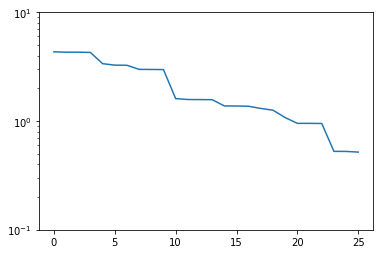

In [23]:
from matplotlib import pyplot as plt
plt.figure()
plt.semilogy(trivial_errors)
plt.ylim(1e-1, 1e1)
plt.show()

Good! We see an exponential decay of the error with growing basis size.
However, we can do better. If we want to use a smaller basis than we
have snapshots available, just picking the first of these obviously
won't be optimal.


Strong greedy algorithm
-----------------------

The strong greedy algorithm iteratively builds reduced spaces
{math}`V_N` with a small worst-case best approximation error on a
training set of solution snapshots by adding, in each iteration, the
currently worst-approximated snapshot vector to the basis of {math}`V_N`.

We can easily implement it as follows:

In [24]:
def strong_greedy(U, product, N):
    basis = U.space.empty()

    for n in range(N):
        # compute projection errors
        G = basis.gramian(product)
        R = basis.inner(U, product=product)
        lambdas = np.linalg.solve(G, R)
        U_proj = basis.lincomb(lambdas.T)
        errors = (U - U_proj).norm(product)

        # extend basis
        basis.append(U[np.argmax(errors)])

    return basis

Obviously, this algorithm is not optimized as we keep computing inner
products we already know, but it will suffice for our purposes. Let's
compute a reduced basis using the strong greedy algorithm:

In [25]:
greedy_basis = strong_greedy(U, fom.h1_0_product, 25)

We compute the approximation errors for the validation set as before:

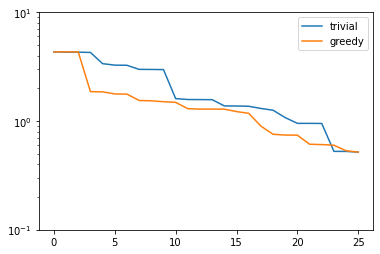

In [26]:
greedy_errors = compute_proj_errors(greedy_basis, V, fom.h1_0_semi_product)

plt.figure()
plt.semilogy(trivial_errors, label='trivial')
plt.semilogy(greedy_errors, label='greedy')
plt.ylim(1e-1, 1e1)
plt.legend()
plt.show()

Indeed, the strong greedy algorithm constructs better bases than the
trivial basis construction algorithm. For compact training sets
contained in a Hilbert space, it can actually be shown that the greedy
algorithm constructs quasi-optimal spaces in the sense that polynomial
or exponential decay of the N-widths {math}`d_N` yields similar rates
for the worst-case best-approximation errors of the constructed {math}`V_N`.


Orthonormalization required
---------------------------

There is one technical problem with both algorithms however: the
condition numbers of the Gramians used to compute the projection
onto {math}`V_N` explode:

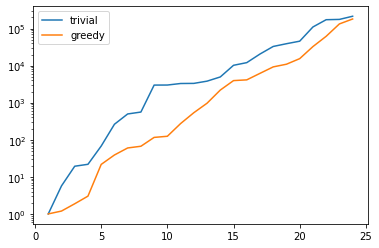

In [27]:
G_trivial = trivial_basis.gramian(fom.h1_0_semi_product)
G_greedy = greedy_basis.gramian(fom.h1_0_semi_product)
trivial_conds, greedy_conds = [], []
for N in range(1, len(U)):
    trivial_conds.append(np.linalg.cond(G_trivial[:N, :N]))
    greedy_conds.append(np.linalg.cond(G_greedy[:N, :N]))
plt.figure()
plt.semilogy(range(1, len(U)), trivial_conds, label='trivial')
plt.semilogy(range(1, len(U)), greedy_conds, label='greedy')
plt.legend()
plt.show()

This is quite obvious as the snapshot matrix `U` becomes more and
more linear dependent the larger it grows.

If we would use the bases we just constructed to build a reduced-order model
from them, we will quickly get bitten by the limited accuracy of floating-point numbers.

There is a simple remedy however: we orthonormalize our bases. The standard
algorithm in pyMOR to do so, is a modified
{meth}`~pymor.algorithms.gram_schmidt.gram_schmidt` procedure with
re-orthogonalization to improve numerical accuracy:

In [28]:
gram_schmidt(greedy_basis, product=fom.h1_0_semi_product, copy=False)
gram_schmidt(trivial_basis, product=fom.h1_0_semi_product, copy=False)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

NumpyVectorArray(
    NumpyVectorSpace(20201, id='STATE'),
    [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  9.72400995e-04
       6.40708268e-04  2.44342521e-04]
     [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.88622177e-04
       1.22198234e-04  4.55954601e-05]
     [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  2.83897552e-03
       1.91768253e-03  7.54420981e-04]
     ...
     [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -6.50683737e-05
      -5.06370720e-05 -2.30770353e-05]
     [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.52117861e-05
      -3.23210341e-05 -1.97290029e-05]
     [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.70725037e-04
      -2.05655123e-04 -9.13433643e-05]],
    _len=25)

The `copy=False` argument tells the algorithm to orthonormalize
the given {{ VectorArray }} in-place instead of returning a new array with
the orthonormalized vectors.

Since the vectors in `greedy_basis` and `trivial_basis` are now orthonormal,
their Gramians are identity matrices (up to numerics). Thus, their condition
numbers should be near 1:

In [29]:
G_trivial = trivial_basis.gramian(fom.h1_0_semi_product)
G_greedy = greedy_basis.gramian(fom.h1_0_semi_product)

print(f'trivial: {np.linalg.cond(G_trivial)}, '
      f'greedy: {np.linalg.cond(G_greedy)}')

trivial: 1.0000000000000038, greedy: 1.0000000000000022


Orthonormalizing the bases does not change their linear span, so
best-approximation errors stay the same. Also, we can
compute these errors now more easily by exploiting orthogonality:

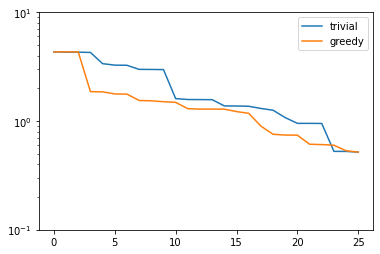

In [30]:
def compute_proj_errors_orth_basis(basis, V, product):
    errors = []
    for N in range(len(basis) + 1):
        v = V.inner(basis[:N], product=product)
        V_proj = basis[:N].lincomb(v)
        errors.append(np.max((V - V_proj).norm(product)))
    return errors

trivial_errors = compute_proj_errors_orth_basis(trivial_basis, V, fom.h1_0_semi_product)
greedy_errors  = compute_proj_errors_orth_basis(greedy_basis, V, fom.h1_0_semi_product)

plt.figure()
plt.semilogy(trivial_errors, label='trivial')
plt.semilogy(greedy_errors, label='greedy')
plt.ylim(1e-1, 1e1)
plt.legend()
plt.show()

Proper Orthogonal Decomposition
-------------------------------

Another popular method to create a reduced basis out of snapshot data is the so-called
Proper Orthogonal Decomposition (POD) which can be seen as a non-centered version of
Principal Component Analysis (PCA). First we build a snapshot matrix

```{math}
A :=
\begin{bmatrix}
\vdots & \vdots & \cdots & \vdots \\
u(\mu_1) & u(\mu_2) & \cdots & u(\mu_K)\\
\vdots & \vdots & \cdots & \vdots
\end{bmatrix},
```

where {math}`K` denotes the total number of solution snapshots. Then we compute the SVD
of {math}`A`

```{math}
A = U \Sigma V^T,
```

where {math}`\Sigma` is an {math}`r \times r`-diagonal matrix, {math}`U` is an {math}`n \times r`-matrix
and {math}`V` is an {math}`K \times r`-matrix. Here {math}`n` denotes the dimension of the
{attr}`~pymor.models.interface.Model.solution_space` and {math}`r` is the rank of {math}`A`.
The diagonal entries {math}`\sigma_i` of {math}`\Sigma` are the singular values of {math}`A`, which are
assumed to be monotonically decreasing. The pairwise orthogonal and normalized
columns of {math}`U` and {math}`V` are the left- resp. right-singular vectors of {math}`A`.
The {math}`i`-th POD mode is than simply the {math}`i`-th left-singular vector of {math}`A`,
i.e. the {math}`i`-th column of {math}`U`. The larger the corresponding singular value is,
the more important is this vector for the approximation of the snapshot data. In fact, if we
let {math}`V_N` be the span of the first {math}`N` left-singular vectors of {math}`A`, then
the following error identity holds:

```{math}
\sum_{k = 1}^K \inf_{v \in V_N} \|u(\mu_k) - v\|^2 =\,
\min_{\substack{W_N \subseteq V\\ \operatorname{dim}(W_N) \leq N}} \sum_{k = 1}^K \inf_{v \in W_N} \|u(\mu_k) - v\|^2 =
\sum_{i = N+1}^{r} \sigma^2
```

Thus, the linear spaces produced by the POD are actually optimal, albeit in a different
error measure: instead of looking at the worst-case best-approximation error over all
{{ parameter_values }}, we minimize the {math}`\ell^2`-sum of all best-approximation errors.
So in the mean squared average, the POD spaces are optimal, but there might be {{ parameter_values }}
for which the best-approximation error is quite large.

So far we completely neglected that the snapshot vectors may lie in a Hilbert space
with some given inner product. To account for that, instead of the snapshot matrix
{math}`A`, we consider the linear mapping that sends the {math}`i`-th canonical basis vector
{math}`e_k` of {math}`\mathbb{R}^K` to the vector {math}`u(\mu_k)` in the
{attr}`~pymor.models.interface.Model.solution_space`:

$$ \Phi: \mathbb{R}^K \to V, \ e_k \mapsto u(\mu_k).$$

Also for this finite-rank (hence compact) operator there exists a SVD of the form

$$ \Phi(v) = \sum_{i=1}^r u_i \cdot \sigma_i \cdot (v_i, v) \qquad \forall v \in \mathbb{R}^K,$$

with orthonormal vectors {math}`u_i` and {math}`v_i` that generalizes the SVD of a matrix.

The POD in this more general form is implemented in pyMOR by the
{meth}`~pymor.algorithms.pod.pod` method, which can be called as follows:

In [31]:
pod_basis, pod_singular_values = pod(U, product=fom.h1_0_semi_product, modes=25)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

We said that the POD modes (left-singular vectors) are orthonormal with respect to the
inner product on the target Hilbert-space. Let's check that:

In [32]:
np.linalg.cond(pod_basis.gramian(fom.h1_0_semi_product))

1.0000000000095441

Now, let us compare how the POD performs against the greedy algorithm in the worst-case
best-approximation error:

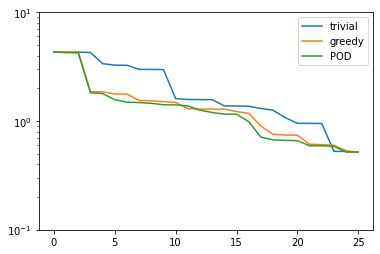

In [33]:
pod_errors = compute_proj_errors_orth_basis(pod_basis, V, fom.h1_0_semi_product)

plt.figure()
plt.semilogy(trivial_errors, label='trivial')
plt.semilogy(greedy_errors, label='greedy')
plt.semilogy(pod_errors, label='POD')
plt.ylim(1e-1, 1e1)
plt.legend()
plt.show()

As it turns out, the POD spaces perform even slightly better than the greedy spaces.
Why is that the case? Note that for finite training or validation sets, both considered error measures
are equivalent. In particular:

```{math}
\sup_{k = 1,\ldots,K} \inf_{v \in V_N} \|u(\mu_k) - v\| \leq
\left[\sum_{k = 1}^K \inf_{v \in V_N} \|u(\mu_k) - v\|^2\right]^{1/2} \leq
\sqrt{K} \cdot \sup_{k = 1,\ldots,K} \inf_{v \in V_N} \|u(\mu_k) - v\|.
```

Since POD spaces are optimal in the {math}`\ell^2`-error, they miss the error of the
optimal space in the Kolmogorov sense by at most a factor of {math}`\sqrt{K}`, which in
our case is {math}`5`. On the other hand, the greedy algorithm also only produces
quasi-optimal spaces. -- For very large training sets with more complex parameter dependence,
differences between both spaces may be more significant.

Finally, it is often insightful to look at the POD modes themselves:

In [34]:
fom.visualize(pod_basis)

<pymor.discretizers.builtin.gui.jupyter.matplotlib.visualize_patch.<locals>.Plot at 0x7f988a185e50>

As you can see, the first (more important) basis vectors account for the approximation of
the solutions in the bulk of the subdomains, whereas the higher modes are responsible for
approximating the solutions at the subdomain interfaces.


Weak greedy algorithm
---------------------

Both POD and the strong greedy algorithm require the computation of all
{meth}`solutions <pymor.models.interface.Model.solve>` {math}`u(\mu)`
for all {{ parameter_values }} {math}`\mu` in the `training_set`. So it is
clear right from the start that we cannot afford very large training sets.
Otherwise we would not be interested in model order reduction
in the first place. This is a problem when the number of |parameters|
increases and/or the solution depends less uniformly on the |parameters|.

Reduced basis methods have a very elegant solution to this problem, which
allows training sets that are orders of magnitude larger than the training
sets affordable for POD: instead of computing the best-approximation error
we only compute a surrogate

$$ \inf_{v \in V_N} \|u(\mu) - v\| \approx \mathcal{E}(\mu)$$

for it. Replacing the best-approximation error by this surrogate in the
[strong greedy](#strong-greedy-algorithm) algorithm, we arrive at the
{meth}`weak greedy <pymor.algorithms.greedy.weak_greedy>`
algorithm. If the surrogate {math}`\mathcal{E}(\mu)` is an upper and lower bound
to the best-approximation error up to some fixed factor, it can still be shown that the
produced reduced spaces are quasi-optimal in the same sense as for the strong greedy
algorithm, although the involved constants might be worse, depending on the
efficiency of {math}`\mathcal{E}(\mu)`.

Now here comes the trick: to get a surrogate that can be quickly computed, we can
use our current reduced-order model for it. More precisely, we choose {math}`\mathcal{E}(\mu)`
to be of the form

$$ \mathcal{E}(\mu):= \operatorname{Err-Est}(\operatorname{ROM-Solve}(\mu), \mu).$$

So to compute the surrogate for fixed {{ parameter_values }} {math}`\mu`, we first
{meth}`~pymor.models.interface.Model.solve` the reduced-order model for the current
reduced basis for these {{ parameter_values }} and then compute an estimate for the
model order reduction error.

We won't go into any further details in this tutorial, but for nice problem classes
(linear coercive problems with an affine dependence of the system matrix on the {{ Parameters }}),
one can derive a posteriori error estimators for which the equivalence with the best-approximation
error can be shown and which can be computed efficiently, independently from the size
of the full-order model. Here we will only give a simple example how to use the
{meth}`weak greedy <pymor.algorithms.greedy.weak_greedy>` algorithm for our problem at hand.

In order to do so, we need to be able to build a reduced-order
model with an appropriate error estimator. For the given (linear coercive) thermal block problem
we can use {class}`~pymor.reductors.coercive.CoerciveRBReductor`:

In [35]:
reductor = CoerciveRBReductor(
    fom,
    product=fom.h1_0_semi_product,
    coercivity_estimator=ExpressionParameterFunctional('min(diffusion)', fom.parameters)
)

Here `product` specifies the inner product with respect to which we want to compute the
model order reduction error. With `coercivity_estimator` we need to specify
a function which estimates the coercivity constant of the system matrix with respect to
the given inner product. In our case, this is just the minimum of the diffusivities over
all subdomains.

Now we can call {meth}`~pymor.algorithms.greedy.rb_greedy`, which constructs for us the
surrogate {math}`\mathcal{E}(\mu)` from `fom` and the `reductor` we just
constructed. It then passes this surrogate to the {meth}`~pymor.algorithms.greedy.weak_greedy`
method. Furthermore, we need to specify the number of basis vectors we want to compute
(we could also have specified an error tolerance) and the training set.
As the surrogate is cheap to evaluate, we choose here a training set of 1000 different
{{ parameter_values }}:

In [36]:
greedy_data = rb_greedy(fom, reductor, parameter_space.sample_randomly(1000),
                        max_extensions=25)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

Take a look at the log output to see how the basis is built iteratively using
the surrogate {math}`\mathcal{E}(\mu)`.

The returned `greedy_data` dictionary contains various information about the run
of the algorithm, including the final ROM. Here, however, we are interested in the
generated reduced basis, which is managed by the `reductor`:

In [37]:
weak_greedy_basis = reductor.bases['RB']

Let's see, how the weak-greedy basis performs:

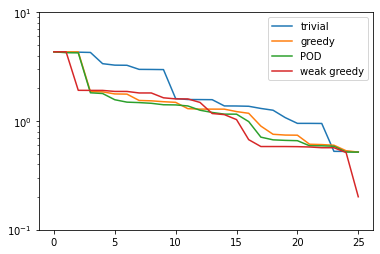

In [38]:
weak_greedy_errors = compute_proj_errors_orth_basis(weak_greedy_basis, V, fom.h1_0_semi_product)

plt.figure()
plt.semilogy(trivial_errors, label='trivial')
plt.semilogy(greedy_errors, label='greedy')
plt.semilogy(pod_errors, label='POD')
plt.semilogy(weak_greedy_errors, label='weak greedy')
plt.ylim(1e-1, 1e1)
plt.legend()
plt.show()

We see that for smaller basis sizes the weak-greedy basis is slightly worse than the POD and
strong-greedy bases. This can be explained by the fact that the surrogate {math}`\mathcal{E}(\mu)`
can over-estimate the actual best-approximation error by a certain (fixed) factor, possibly
resulting in the selection of sub-optimal snapshots. For larger basis sizes, this is mitigated
by the very large training set from which we were able to choose: the 25 snapshots in `training_set` used
for the POD and strong-greedy bases can approximate the entire manifold of solutions only to
a certain degree, whereas the weak-greedy algorithm could select the snapshots from 1000 possible
{{ parameter_values }}.


Download the code:
{download}`tutorial_basis_generation.md`
{nb-download}`tutorial_basis_generation.ipynb`